# Linear Classifiers

<br />
<br />
<br />

### Table of Contents

* Introduction
* Loading the Dataset
* Creating Linear Classifier Model

<br />
<br />
<br />


## Introduction

Linear classifier algorithms are similar in spirit to linear regression, but with the difference that the system response variable is no longer continuous, but categorical. This means we can't use something like a Pearson's $R^2$ coefficient.

In [82]:
%matplotlib inline

# numbers, stats, plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

# sklearn support
from sklearn import metrics, cross_validation, preprocessing
from sklearn.datasets.base import Bunch
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit, StratifiedKFold

# machine learning algorithm of interest
from sklearn.svm import LinearSVC

#import pickle
from pprint import pprint

## Loading Dataset

Start by loading the dataset into a scikit learn `Bundle` object:

In [13]:
def load_data_with_volume():
    
    # Load the data from this file
    data_file = 'abalone/Dataset.data'
    
    # x data labels
    xnlabs = ['Sex']
    xqlabs = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
    xlabs = xnlabs + xqlabs

    # y data labels
    ylabs = ['Rings']

    # Load data to dataframe
    df = pd.read_csv(data_file, header=None, sep=' ', names=xlabs+ylabs)
    
    # Filter zero values of height/length/diameter
    df = df[df['Height']>0.0]
    df = df[df['Length']>0.0]
    df = df[df['Diameter']>0.0]
    
    df['Volume'] = df['Height']*df['Length']*df['Diameter']
    xqlabs.append('Volume')
    
    dummies = pd.get_dummies(df[xnlabs], prefix='Sex')
    
    dfdummies = df[xqlabs+ylabs].join(dummies)
    
    xqlabs = xqlabs + dummies.columns.tolist()
    
    return Bunch(data   = dfdummies[xqlabs],
                 target = df[ylabs],
                 feature_names = xqlabs,
                 target_names  = ylabs)


In [14]:
# Load the dataset
dataset = load_data_with_volume()
X = dataset.data
y = dataset.target

In [56]:
# Split  into a training set and a test set
X_train, X_test, y_train, y_test = \
                    cross_validation.train_test_split(X, y, test_size=0.2)

In [57]:
def make_spiffy(y):
    # Turns an (N,1) array into an (N,) array (yeeeaaaaah...)
    return y.values.reshape(len(y.values))

## Creating a Linear Classifier Pipeline

Next step is to create a pipeline connecting a linear state vector classifier to a scaler, and hooking those up to a cross-validator to print out scores for different ways of cutting the data.

In [146]:
# Make a state vector machine classifier
mod = LinearSVC()

# Make a ShuffleSplit object to split data into training/testing data sets randomly
cv = ShuffleSplit(n_splits=4, test_size=0.3, random_state=0)

# This will be our "model":
# a pipeline that scales our inputs first, 
# then passes them to the logistic regression model
clf = make_pipeline(preprocessing.StandardScaler(), mod)
cross_val_score(clf, X, make_spiffy(y), cv=cv)

array([ 0.26496409,  0.25219473,  0.24421389,  0.23463687])

Okay - as expected, the linear classifier is not so great, but it is no worse than logistic regression. Let's visualize the linear classifier:

In [147]:
# Color by number of rings
colors = y['Rings'].map(lambda x : float(x)).values

colors -= colors.min()
colors *= (1.0/colors.max())

cm = plt.cm.jet
plot_color = cm(colors)

In [148]:
print X.shape

(4175, 11)


Because we have 11 dimensions, it won't be possible to visualize the classifier, really, but we can give it our best shot. First, here is the plain scatterplot:

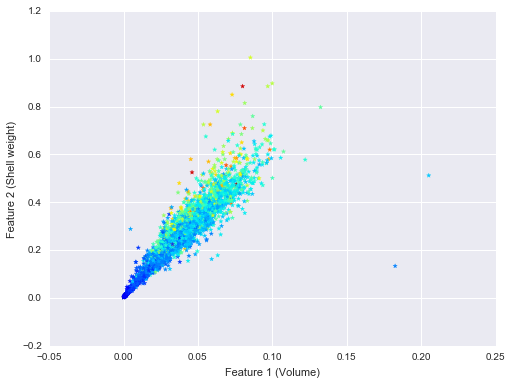

In [149]:
fig = plt.figure(figsize=(8,6))
lab1 = "Volume"
lab2 = "Shell weight"
plt.scatter(X[lab1], X[lab2],
            color=plot_color,
            marker='*')
plt.xlabel("Feature 1 (%s)"%(lab1))
plt.ylabel("Feature 2 (%s)"%(lab2))
plt.show()

To approximate the classifier boundaries, we'll pull apart the linear svc model and get at its coefficients, and project the class boundary onto the Feature 1/Feature 2 axis.

In [150]:
#print dir(clf)

In [151]:
clf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [152]:
yhat_test = clf.predict(X_test)

In [153]:
resid = make_spiffy(y_test) - yhat_test
print np.mean(resid)
print np.std(resid)

1.12934131737
2.53266826651


In [154]:
svc_params = clf.get_params()

In [155]:
#pprint(svc_params.keys())

In [156]:
#print dir(svc_params['linearsvc'])

In [157]:
print svc_params['linearsvc'].coef_.shape

(26, 11)


26 classes, 11 coefficients each - that (almost) corresponds to our case of 28 classes of rings, and 11 input variables:

In [158]:
print len(y['Rings'].unique())

28


In [159]:
print X.shape

(4175, 11)


In [160]:
svc_coef = svc_params['linearsvc'].coef_

Now to plot the classification line on the scatterplot, we'll take a shot in the dark, and grab only those two coefficients for each age.

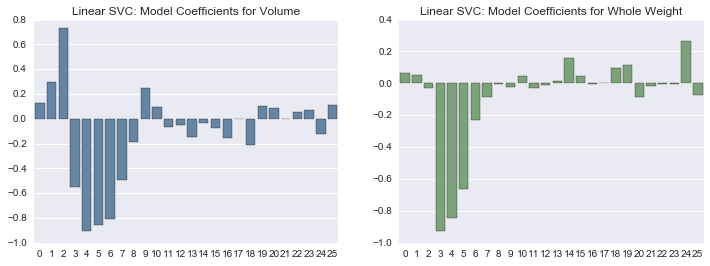

In [184]:
volume_index = X.columns.tolist().index('Volume')
wt_index = X.columns.tolist().index('Shell weight')

volume_coefs = svc_coef[:,volume_index]
wt_coefs = svc_coef[:,wt_index]

fig = plt.figure(figsize=(12,4))
ax1, ax2 = [fig.add_subplot(j) for j in [121, 122]]

sns.barplot(range(len(volume_coefs)), volume_coefs, color=sns.xkcd_rgb['dusty blue'], ax=ax1)
ax1.set_title('Linear SVC: Model Coefficients for Volume')

sns.barplot(range(len(wt_coefs)), wt_coefs, color=sns.xkcd_rgb['dusty green'], ax=ax2)
ax2.set_title('Linear SVC: Model Coefficients for Whole Weight')

plt.show()

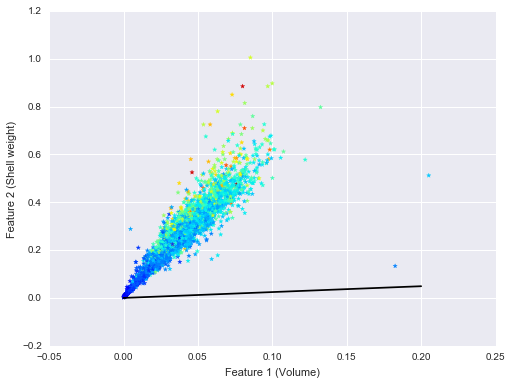

In [196]:
fig = plt.figure(figsize=(8,6))
lab1 = "Volume"
lab2 = "Shell weight"
plt.scatter(X[lab1], X[lab2],
            color=plot_color,
            marker='*')

xfit = np.linspace(0.0,0.2,50)
yfit = volume_coefs[9]*xfit # <-- this is missing a bunch of other terms, so it will be way off

plt.plot(xfit,yfit,'k-')

plt.xlabel("Feature 1 (%s)"%(lab1))
plt.ylabel("Feature 2 (%s)"%(lab2))
plt.show()

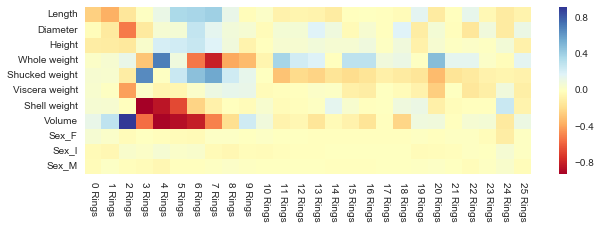

In [143]:
fig = plt.figure(figsize=(10,3))
sns.heatmap(svc_coef.T,
            cmap="RdYlBu"
           )

# Don't forget to flip the y-axis labels using [::-1]
# Oh, and scooch the labels up by 0.5.
plt.yticks([z+0.5 for z in range(dataset.data.shape[1])], dataset.feature_names[::-1], rotation=0)
plt.xticks([z+0.5 for z in range(26)], ["%s Rings"%(z) for z in range(26)], rotation=270)

plt.show()

This heat map of linear classifier coefficients tells us quite a bit about how this linear classifier works:
* The blue spots indicate positive coefficients: when this input variable _increases_, this class tends to become _more likely_. 
* The red spots indicate negative coefficeints: when this input variable _decreases_, this class tends to become _less likely_.

Examining the length, diameter, and height variables shows that larger physical dimensions on an abalone indicate that the abalone is likely to have 3-7 rings. However, that is subject to the fact that as the volume increases, the likelihood of an abalone having less than 9 rings becomes extremely small. (These aren't mutually exclusive: if an abalone is large in one dimension but small in two others, that would lead to one large physical dimension simultaneous with a small volume). 

A larger shucked weight indicates the abalone is likely to have 3-9 ring, but a larger whole weight makes it more likely to have over 10 rings.

Does the sex matter? Very faint blue and red lines for the female, male, and infant categories indicate that sex has only the slightest effect on classification, but classifying an abalone as an infant means it is more likely to be classified with fewer than 7 rings.

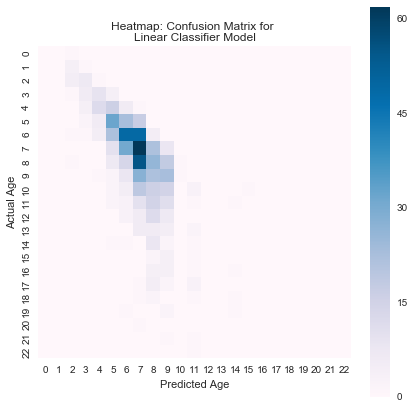

In [145]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
sns.heatmap(metrics.confusion_matrix(y_test, yhat_test),
           cmap="PuBu", square=True, ax=ax)
ax.set_title('Heatmap: Confusion Matrix for \nLinear Classifier Model')
ax.set_xlabel('Predicted Age')
ax.set_ylabel('Actual Age')
plt.show()